In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [35]:
from torchvision.transforms import Compose, ToTensor
from torchsummary import summary
import pickle
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [13]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.models.mlp_dropout import MLPDropout
from base_code.training.cewc_v1 import CEWC

# Dataset and definitions

## Preprocessing definitions

In [5]:
train_transform = Compose(
    [
        ToTensor(),
    ]
)

test_transform = Compose(
    [
        ToTensor(),
    ]
)

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
# mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=train_transform)
# mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=test_transform)

scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
# scenario = nc_benchmark(
#     mnist_train, mnist_test,
#     n_experiences=len(mnist_train.classes), shuffle=True, seed=1234, task_labels=False
# )

train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [43]:
# model = MLP(n_classes=scenario.n_classes, n_channels=1, width=28, height=28)
model = MLPDropout(n_classes=scenario.n_classes, width=28, height=28, n_channels=1)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()
strategy = CEWC(
    model,
    optimizer,
    criterion,
    ewc_lambda_l1=1.0,
    ewc_lambda_l2=1.0,
    train_epochs=5,
    train_mb_size=128,
    evaluator=eval_plugin,
    eval_mb_size=128,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

In [44]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
Used params initialized to zero tensor([False, False, False,  ..., False, False, False])
100%|██████████| 469/469 [00:06<00:00, 71.50it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 70.64it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 70.95it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.87it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.94it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 118.22it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8012
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 120.79it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1508
-- Starting eval on experien

 10%|█         | 1/10 [00:43<06:32, 43.61s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1773
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2100
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 69.87it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 69.70it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 68.27it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.34it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.12it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 120.89it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7720
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 120.11it/s]
> Eval on experience 1 (Task 

 20%|██        | 2/10 [01:28<05:52, 44.08s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2283
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2869
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 69.15it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 69.67it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 69.59it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.40it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.36it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 125.17it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7643
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 120.25it/s]
> Eval on experience 1 (Task 

 30%|███       | 3/10 [02:12<05:09, 44.16s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1667
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3403
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 71.29it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 70.78it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 71.20it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 68.66it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.18it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 121.97it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7019
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 120.15it/s]
> Eval on experience 1 (Task 

 40%|████      | 4/10 [02:56<04:24, 44.04s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1409
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3977
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 69.41it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 69.26it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 69.47it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.64it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 70.05it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 123.71it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6969
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 121.76it/s]
> Eval on experience 1 (Task 

 50%|█████     | 5/10 [03:40<03:40, 44.04s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1756
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4663
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 70.08it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 70.32it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 70.09it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 70.26it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 70.23it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 125.12it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6446
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 121.49it/s]
> Eval on experience 1 (Task 

 60%|██████    | 6/10 [04:23<02:55, 43.93s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1495
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5295
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 70.46it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 70.50it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 70.45it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 70.38it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 70.51it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 126.09it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6675
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 124.45it/s]
> Eval on experience 1 (Task 

 70%|███████   | 7/10 [05:07<02:11, 43.81s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1518
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5940
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 70.31it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 70.52it/s]
Epoch 1 ended.
100%|██████████| 469/469 [03:45<00:00,  2.08it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 68.69it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 70.46it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 125.59it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6009
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 125.35it/s]
> Eval on experience 1 (Task 

 80%|████████  | 8/10 [09:30<03:46, 113.45s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1589
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6464
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 69.70it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 69.86it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 69.62it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.67it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.78it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 123.81it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6151
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 124.06it/s]
> Eval on experience 1 (Task 

 90%|█████████ | 9/10 [10:14<01:31, 91.74s/it] 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1649
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7118
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 69.67it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 68.92it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 69.11it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 69.48it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 69.47it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 121.64it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6061
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 123.61it/s]
> Eval on experience 1 (Task 

100%|██████████| 10/10 [10:58<00:00, 65.82s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.8598
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7692


In [45]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1][-10:]

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1][-10:]

In [46]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(10)

<Axes: >

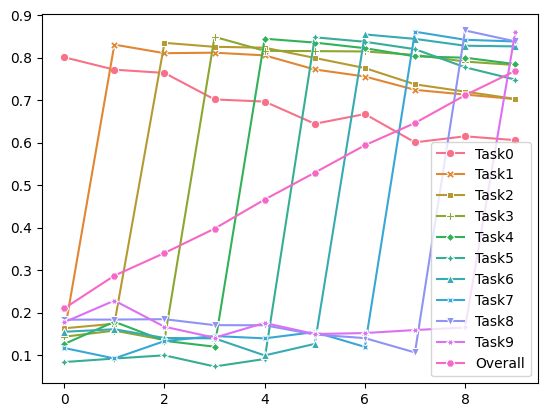

In [47]:
# lineplot every task acc per training
sns.lineplot(data=acc_df, dashes=False, markers=True)

# Qué clase se entrenó en cada tarea / experiencia?

# Store metrics

In [48]:
pickle.dump(accuracies, open(SAVED_METRICS_PATH / "cewc_v1_kirkpatrick.pkl", "wb"))